# Project: ML to Automatically Detect Negative Reviews.

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import re

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

The data was saved in the `df_reviews` variable, which contained a total of 18 columns, and 47331 entries, each describing a review for a movie. The columns that we were interested for our analysis are listed, with its description, below: 

- __review__: the review text
- __pos__: the target, '0' for negative and '1' for positive
- __ds_part__: 'train'/'test' for the train/test part of dataset, correspondingly

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

### Preparing the columns for Analysis

#### __review__ colmn 
The column `review` did not contain any missing values and it had a correct datatype as object. 

In [7]:
df_reviews.review.isna().sum()

0

#### __pos__ column 
The `pos` column did not present any missing values and it had a correct datatype as int64

In [8]:
df_reviews['pos'].isna().sum()

0

In [9]:
df_reviews.pos.unique()

array([0, 1])

#### __ds_part__ column 
The `ds_part` column did not present any missing values, and it had  a correct datatype as object. 

In [10]:
df_reviews['ds_part'].isna().sum()

0

In [11]:
df_reviews.ds_part.unique()

array(['train', 'test'], dtype=object)

## EDA

In this section, we analyzed the number of movies and reviews over years. From the `Number of Movies Over Years` plot, the distributon of movies per year presented a negatively skewed distribution. The top 5 years that presented the highest number of movies were 2006, 2005, 2003, 2004, and 2000 with movie counts of 381.0, 358.0, 305.0, 298.0, and 287.0. The year that had the least, non-zero, number of movies released were 1964, 1894, 1910, 1902, 1912 with movie counts of 1.0. The distribution presented a mean, median, and standard deviation values of 52.34 movies, 26.0 movies and 78.76 movies. 

The `Number Over The Years` plot presented a negatively skewed distribution of number of reviews over time, in years. The top 5 years with the highest number reviews were 2006, 2005, 2004, and 2000 with number of reviews of 3275.0, 3076.0, 2355.0, 2228.0 and 2108.0, respectively. The years that had the lowest, non-zero, amount of reviews per year were 1902, 1910, 1912, 1964, and 1908 with review counts of 1, 1,1,1, and 2.0, respectively. The distribution presented a mean, median, and standard deviation values of 372.68, 124.0 and 627.91 reviews, respectively. 

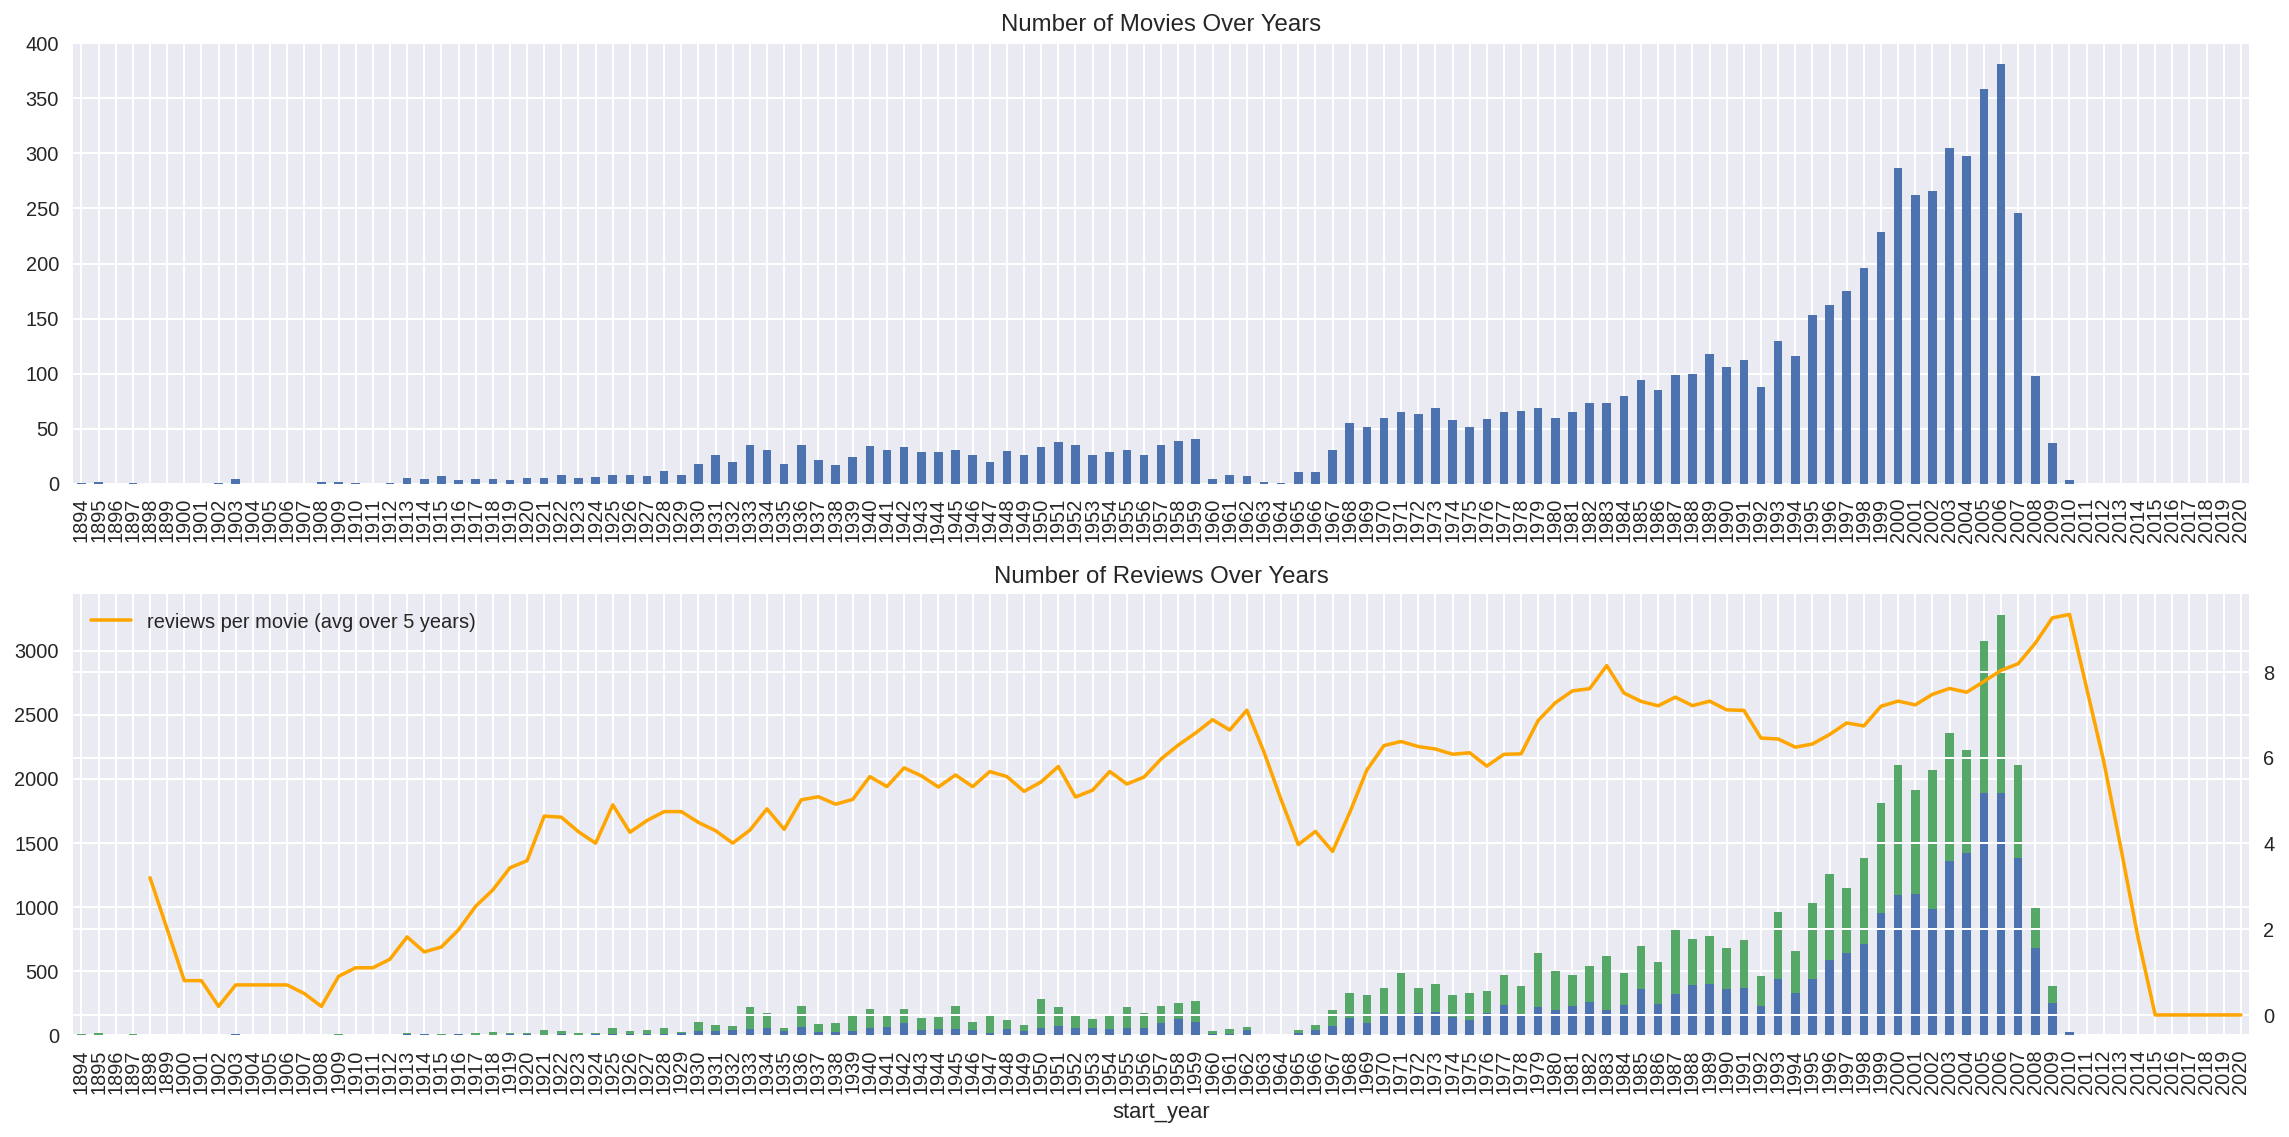

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

In [13]:
#statistical analysis for dft1 
print('Top 5 years with highest number of movies')
print(dft1.sort_values(ascending=False).head(5))
print()
print('Top 5 years with lowest number of movies')
print(dft1.sort_values(ascending=True).head(30))

Top 5 years with highest number of movies
2006    381.0
2005    358.0
2003    305.0
2004    298.0
2000    287.0
Name: start_year, dtype: float64

Top 5 years with lowest number of movies
2020    0.0
2011    0.0
1911    0.0
2012    0.0
2013    0.0
2014    0.0
1907    0.0
1906    0.0
1905    0.0
1904    0.0
2016    0.0
1901    0.0
1900    0.0
1899    0.0
1898    0.0
2017    0.0
1896    0.0
2018    0.0
2015    0.0
2019    0.0
1964    1.0
1894    1.0
1910    1.0
1902    1.0
1912    1.0
1897    1.0
1963    2.0
1909    2.0
1908    2.0
1895    2.0
Name: start_year, dtype: float64


In [14]:
print(dft1.mean())
print(dft1.median())
print(dft1.std())

52.346456692913385
26.0
78.76400132047634


In [15]:
#statistical analysis for dft2
print('Top 5 years with highest number of reviews')
print(dft2.sort_values(ascending=False).head(5))
print()
print('Top 5 years with lowest number of reviews')
print(dft2.sort_values(ascending=True).head(30))

Top 5 years with highest number of reviews
2006    3275.0
2005    3076.0
2003    2355.0
2004    2228.0
2000    2108.0
Name: start_year, dtype: float64

Top 5 years with lowest number of reviews
2020    0.0
2011    0.0
2012    0.0
2013    0.0
2014    0.0
2015    0.0
1911    0.0
2016    0.0
1906    0.0
1905    0.0
1907    0.0
2017    0.0
1901    0.0
1900    0.0
1899    0.0
1898    0.0
1896    0.0
2018    0.0
1904    0.0
2019    0.0
1902    1.0
1910    1.0
1912    1.0
1964    1.0
1908    2.0
1963    3.0
1897    4.0
1894    6.0
1916    6.0
1914    7.0
Name: start_year, dtype: float64


In [16]:
print(dft2.mean())
print(dft2.median())
print(dft2.std())

372.68503937007875
124.0
627.9132194209719


In this section, we analyzed the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting). The histogram and the kernel density estimate plot showed a positively skwewed distributon, with a local maximum number of reviews arounf movie with label '30'. 

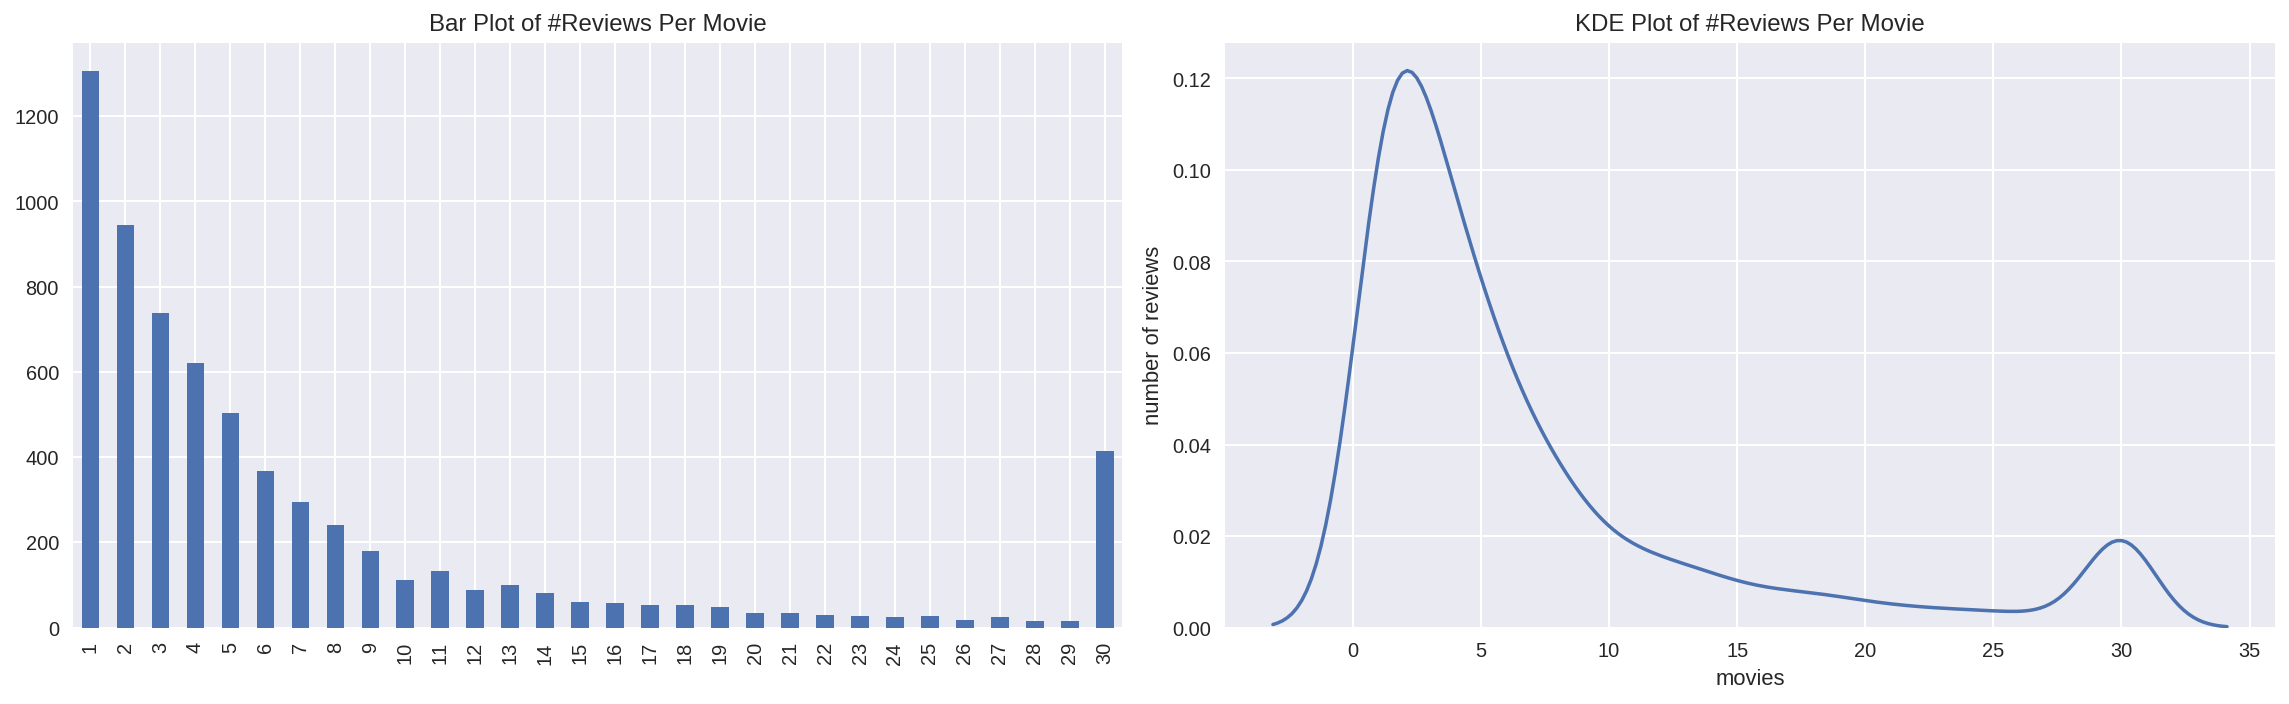

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')
plt.xlabel('movies')
plt.ylabel('number of reviews')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In this section, we analyzed the distributions of ratings between the train set and the test set. From the plots below, we conclude that the distribution of ratings between the two sets are similarly distrubuted, with ratings 9 and 2 having the maximum amount of counts for both sets. The train set had rating counts, for ratings 9 and 2, with values of 2153 and 2155, respectively. The test set presented rating counts, for ratings 2 and 9, with values of 2184 and 2190, respectively. The rating that presented the smallest rating counts was 1 for train and test set with count values of 4863 and 4726, respectively. 

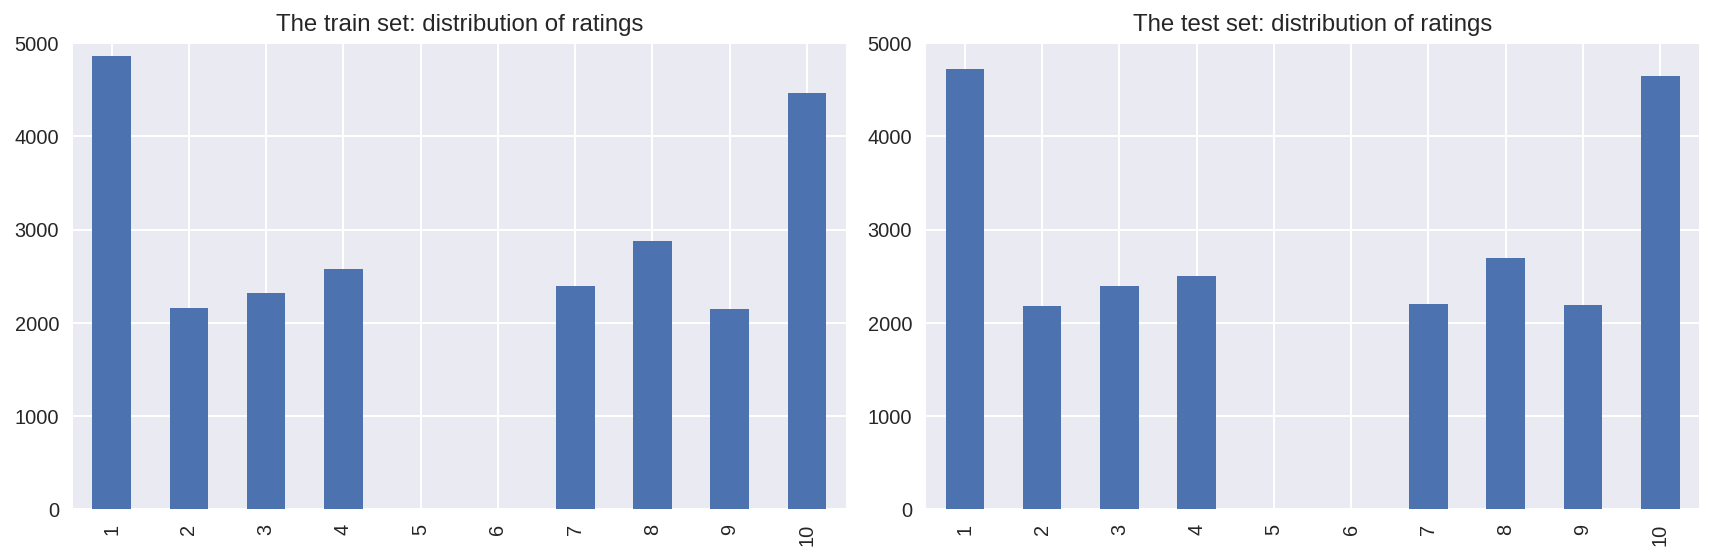

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In [19]:
df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_values()

9     2153
2     2155
3     2317
7     2393
4     2577
8     2876
10    4462
1     4863
Name: rating, dtype: int64

In [20]:
df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_values()

2     2184
9     2190
7     2200
3     2392
4     2501
8     2700
10    4642
1     4726
Name: rating, dtype: int64

In this section, we analyzed the distribution of negative and positive reviews over the years for two parts of the dataset. Overall, the 'pos' columns in the train set presented 50.06% for values of 0; and 49.94% for values of 1. Similarly, the 'pos' column in the test set presented 50.15% for values of 0; and 49.84% for values of 1. The plot below illustrate the distribution of number of review of different polarities per year for both sets. The plots in the right depict that the positive, or value in 'pos' column equals to 1, has had a higher amount of counts throught the years. In constrast, the plots on the left depict the kernel density estimate distribution of review polarities per movie. The distrubutions are postiively skewed and how the postiive review polarity is much higher than the negative polarity. 

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


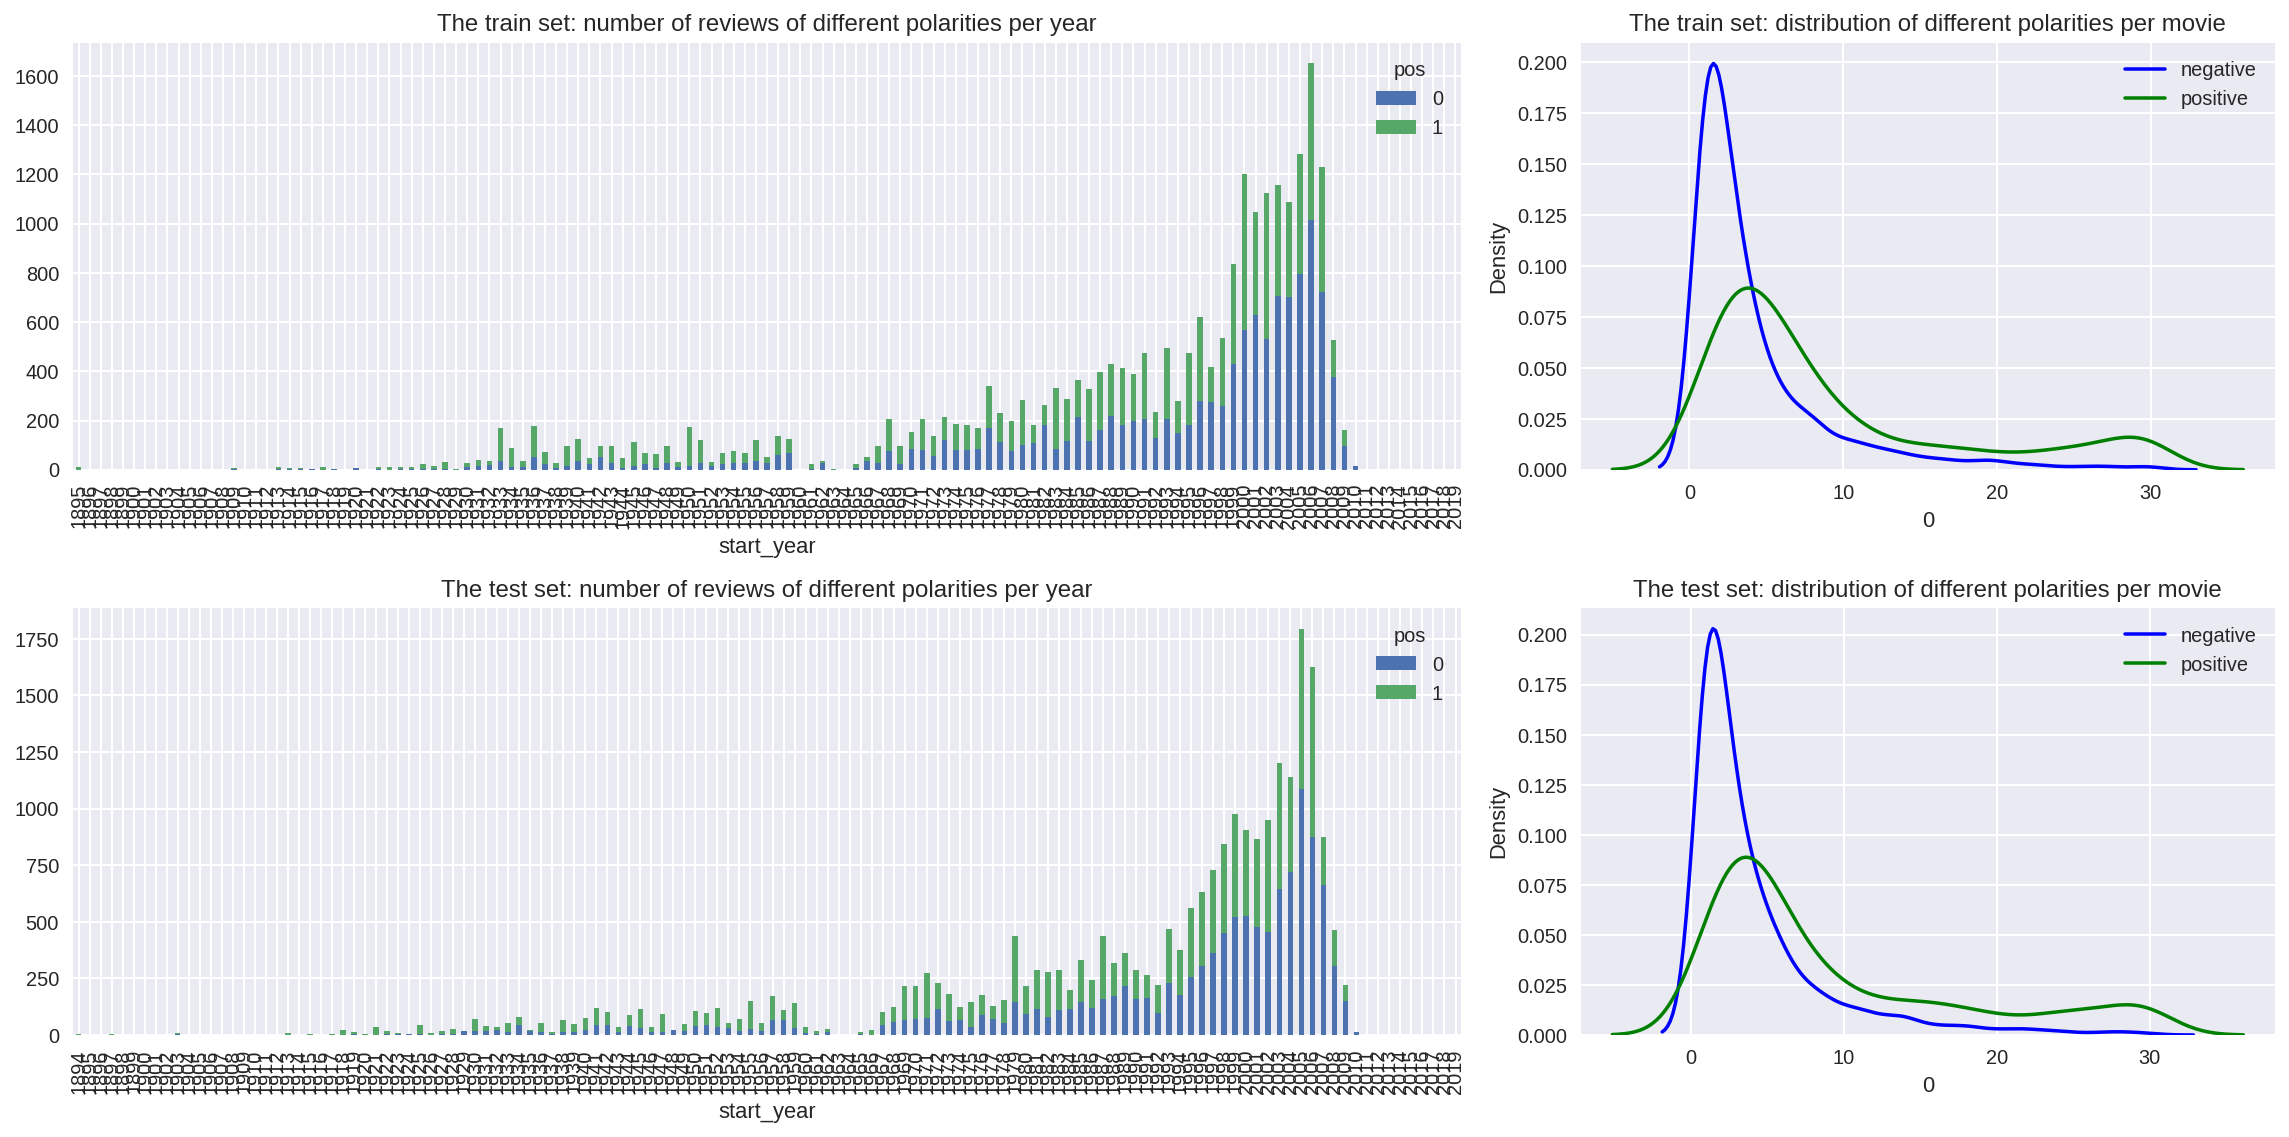

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

In [22]:
#train set pos distribution 
df_reviews.query('ds_part == "train"')['pos'].value_counts(normalize=True)

0    0.500588
1    0.499412
Name: pos, dtype: float64

In [23]:
df_reviews.query('ds_part == "test"')['pos'].value_counts(normalize=True)

0    0.501508
1    0.498492
Name: pos, dtype: float64

## Evaluation Procedure

The `evaluate_model` function was created to evaluate the accuracy, APS, ROC AUC, and F1 score for the training and testing sets, for each model. 

In [24]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [25]:
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


In [ ]:
corpus = df_reviews['review'].to_list()

In [27]:
def clear_text(text):

    pattern = r"[^a-zA-z']" 
    text = re.sub(pattern, " ", str(text)).split()
    text = " ".join(text)
    return text.lower()





In [28]:
new_corpus = []
for row in corpus:
    new_corpus.append(clear_text(row))

In [29]:
new_corpus[0]

"the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that's not what i got out of it i didn't get anything in the first half there's a new character without introduction in every other scene the first half hour is completely incomprehensible the rest is just one long annoying underlit chase scene there's always an irritating sound in the background whether it's a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of parts that are laughably bad too like the bad guys chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen times i really hated this movie"

In [30]:
df_reviews['review_norm'] = new_corpus
df_reviews


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in sing...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,i'm totally agree with garryjohal from singapo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038,this is another of my favorite columbos it spo...
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989,talk about being boring i got this expecting a...
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163,i never thought i'd say this about a biopic bu...
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164,spirit and chaos is an artistic biopic of miya...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [31]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [32]:
from sklearn.dummy import DummyClassifier

In [33]:
train_features_model_0 = df_reviews.query('ds_part == "train"')['review_norm']
test_features_model_0 = df_reviews.query('ds_part == "test"')['review_norm']

In [34]:
model_0 = DummyClassifier()

In [35]:
model_0.fit(train_features_model_0, train_target)

DummyClassifier()

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


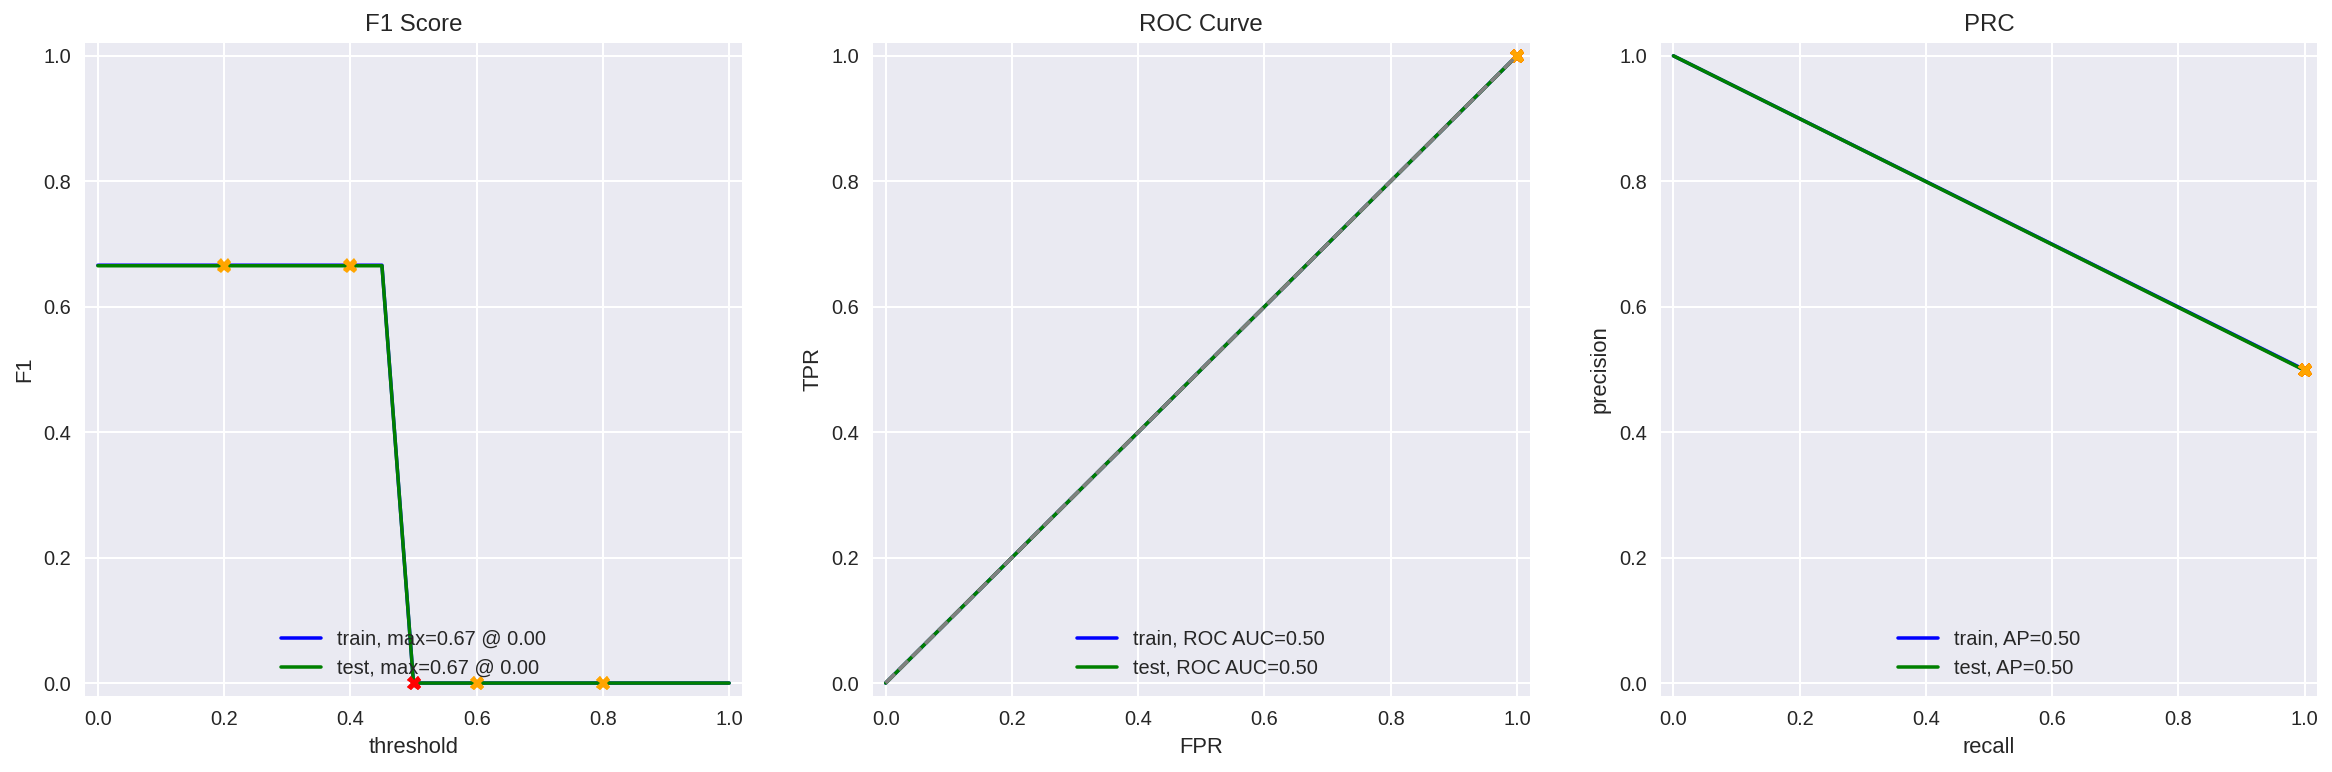

In [36]:
evaluate_model(model_0, train_features_model_0, train_target, test_features_model_0, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [37]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 

In [38]:
#creating corpuses for training/testing data
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

print(corpus_train.shape)
print(corpus_test.shape)

(23796,)
(23535,)


In [39]:
#lemmatizing corpuses using NLTK 
model_1_corpus_train_lem = []

for row in corpus_train.to_list():
    lemmatizer  = WordNetLemmatizer() 
    tokens = word_tokenize(row.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    model_1_corpus_train_lem.append(" ".join(lemmas))

len(model_1_corpus_train_lem)

23796

In [40]:
model_1_corpus_test_lem = []

for row in corpus_test.to_list():
    lemmatizer  = WordNetLemmatizer() 
    tokens = word_tokenize(row.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    model_1_corpus_test_lem.append(" ".join(lemmas))

len(model_1_corpus_test_lem)

23535

In [41]:
#creating features for training/testing with td_idf values
train_features_1 = count_tf_idf.fit_transform(model_1_corpus_train_lem) 
print(train_features_1.shape)
test_features_1 = count_tf_idf.transform(model_1_corpus_test_lem)
print(test_features_1.shape)

(23796, 64447)
(23535, 64447)


In [42]:
#creating variables for other models that will use NLTK lemmatized, tf-idf features 
nltk_features_train = train_features_1
nltk_features_test = test_features_1

In [43]:
#model 1 
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


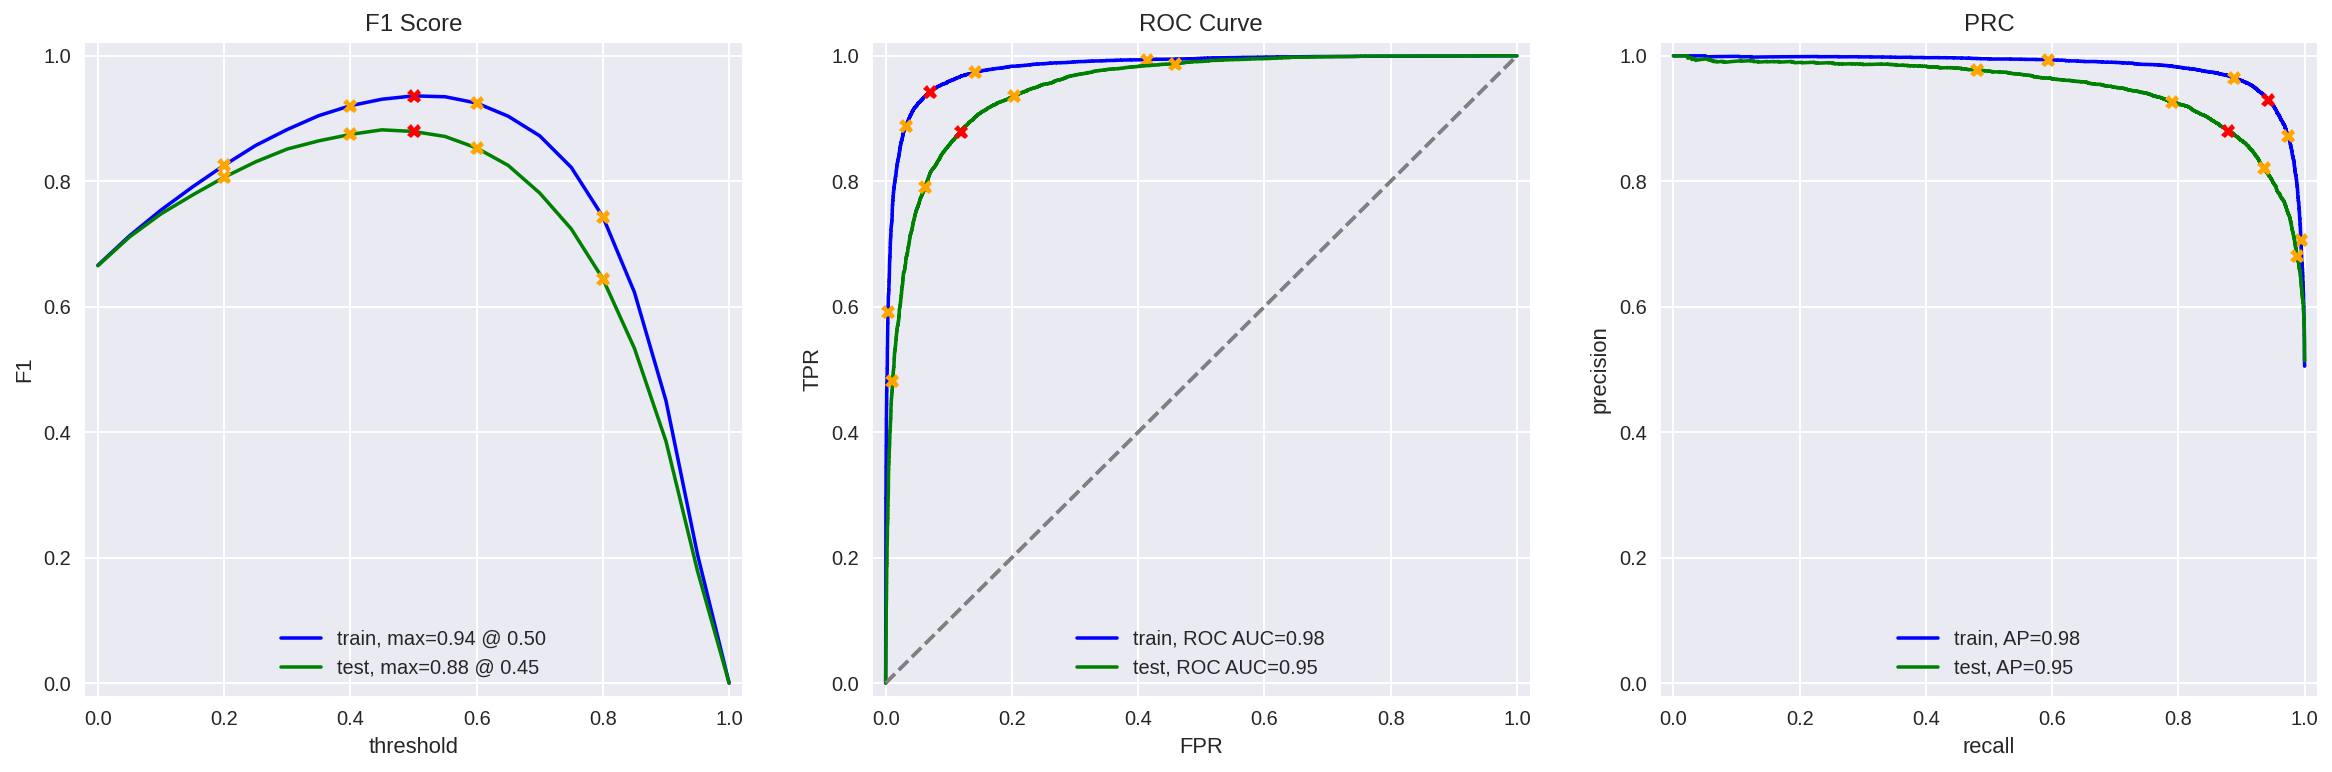

In [44]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - spaCy, TF-IDF and LR

In [45]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [46]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)


In [47]:
spacy_features_train_lem = []

for row in corpus_train.to_list():
    new = text_preprocessing_3(row)
    spacy_features_train_lem.append(new)



In [48]:
len(spacy_features_train_lem)

23796

In [49]:
spacy_features_test_lem = []

for row in corpus_test.to_list():
    new = text_preprocessing_3(row)
    spacy_features_test_lem.append(new)

len(spacy_features_test_lem)

23535

In [50]:
#creating features for training/testing with td_idf values
train_features_2 = count_tf_idf.fit_transform(spacy_features_train_lem)
test_features_2 = count_tf_idf.transform(spacy_features_test_lem)


In [51]:
print(train_features_2.shape)
print(test_features_2.shape)

(23796, 59165)
(23535, 59165)


In [52]:
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


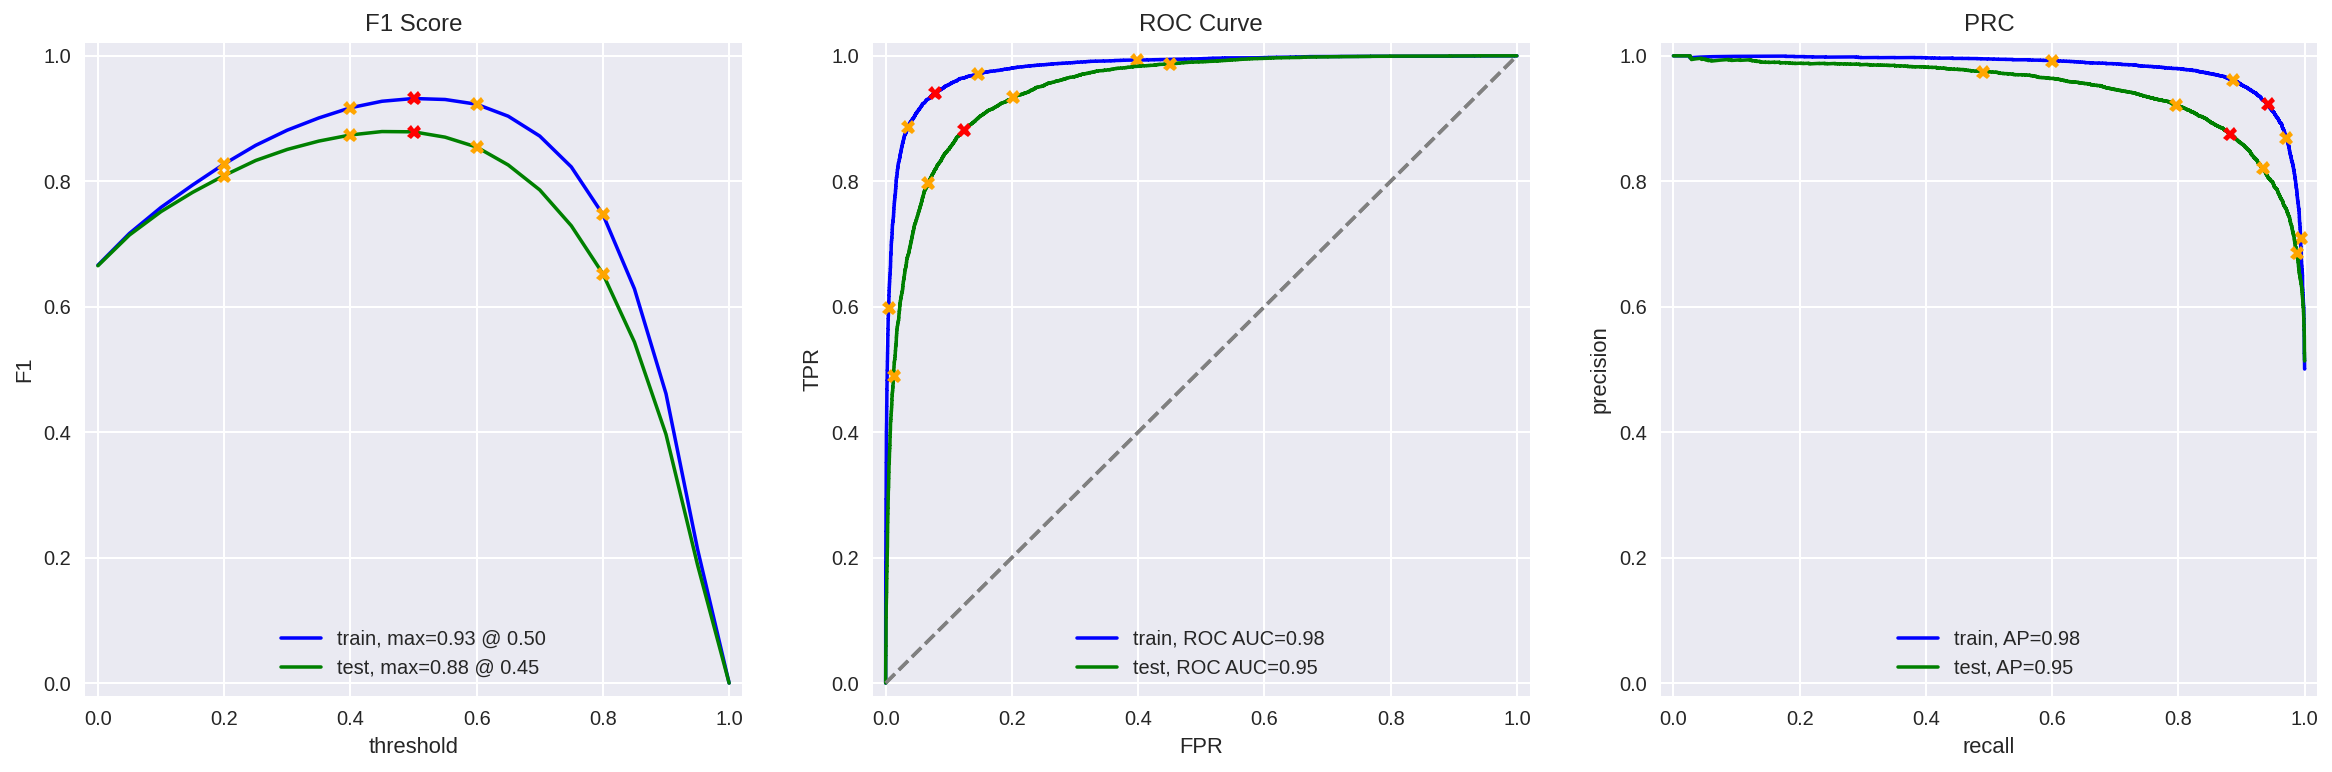

In [53]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [54]:
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [55]:
#hyperparameter tunning

num_leaves = list(np.arange(0,30,2 ))
min_data_in_leaf = list(np.arange(0,20,1))
max_depth  = list(np.arange(0,15,1))

In [56]:
#hyperparameter used for tunning with RandomizedSearchCV 
param_grid = {'num_leaves' : num_leaves, 
              'min_data_in_leaf' : min_data_in_leaf, 
              'max_depth' : max_depth }

In [57]:
lgbmc_model = LGBMClassifier()
lgbmc_random = RandomizedSearchCV(estimator = lgbmc_model, 
                       param_distributions = param_grid,
                       cv = 3, 
                       scoring= 'accuracy',
                       verbose = 2, 
                       return_train_score=True)
lgbmc_random.fit(train_features_2, train_target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[CV] END ......max_depth=8, min_data_in_leaf=5, num_leaves=4; total time=  10.0s
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[CV] END ......max_depth=8, min_data_in_leaf=5, num_leaves=4; total time=  10.2s
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[CV] END ......max_depth=8, min_data_in_leaf=5, num_leaves=4; total time=   9.8s
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[CV] END ....max_depth=8, min_data_in_leaf=13, num_leaves=24; total time=  11.7s
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[CV] END ..

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/opt/conda/lib/

[CV] END ......max_depth=3, min_data_in_leaf=0, num_leaves=6; total time=  20.5s
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[CV] END ......max_depth=3, min_data_in_leaf=0, num_leaves=6; total time=  20.0s
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[CV] END ......max_depth=3, min_data_in_leaf=0, num_leaves=6; total time=  19.4s
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.79794924 0.83085393 0.84001513 0.82114641 0.83211464 0.83400572
 0.82434023 0.79794924        nan 0.80261388]
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.81072449 0.90357623 0.92259203 0.84606657 0.87193226 0.91441839
 0.88294251 0.81072449        nan 0.82356278]
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14],
                                        'min_data_in_leaf': [0, 1, 2, 3, 4, 5,
                                                             6, 7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19],
                                        'num_leaves': [0, 2, 4, 6, 8, 10, 12,
                                                       14, 16, 18, 20, 22, 24,
                                                       26, 28]},
                   return_train_score=True, scoring='accuracy', verbose=2)

In [58]:
lgbmc_random.best_params_

{'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 13}

In [59]:
model_3 = LGBMClassifier(num_leaves = lgbmc_random.best_params_['num_leaves'], 
                         min_data_in_leaf = lgbmc_random.best_params_['min_data_in_leaf'], 
                         max_depth = lgbmc_random.best_params_['max_depth'])
model_3.fit(train_features_2, train_target)

LGBMClassifier(max_depth=13, min_data_in_leaf=11, num_leaves=28)

          train  test
Accuracy   0.90  0.85
F1         0.90  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


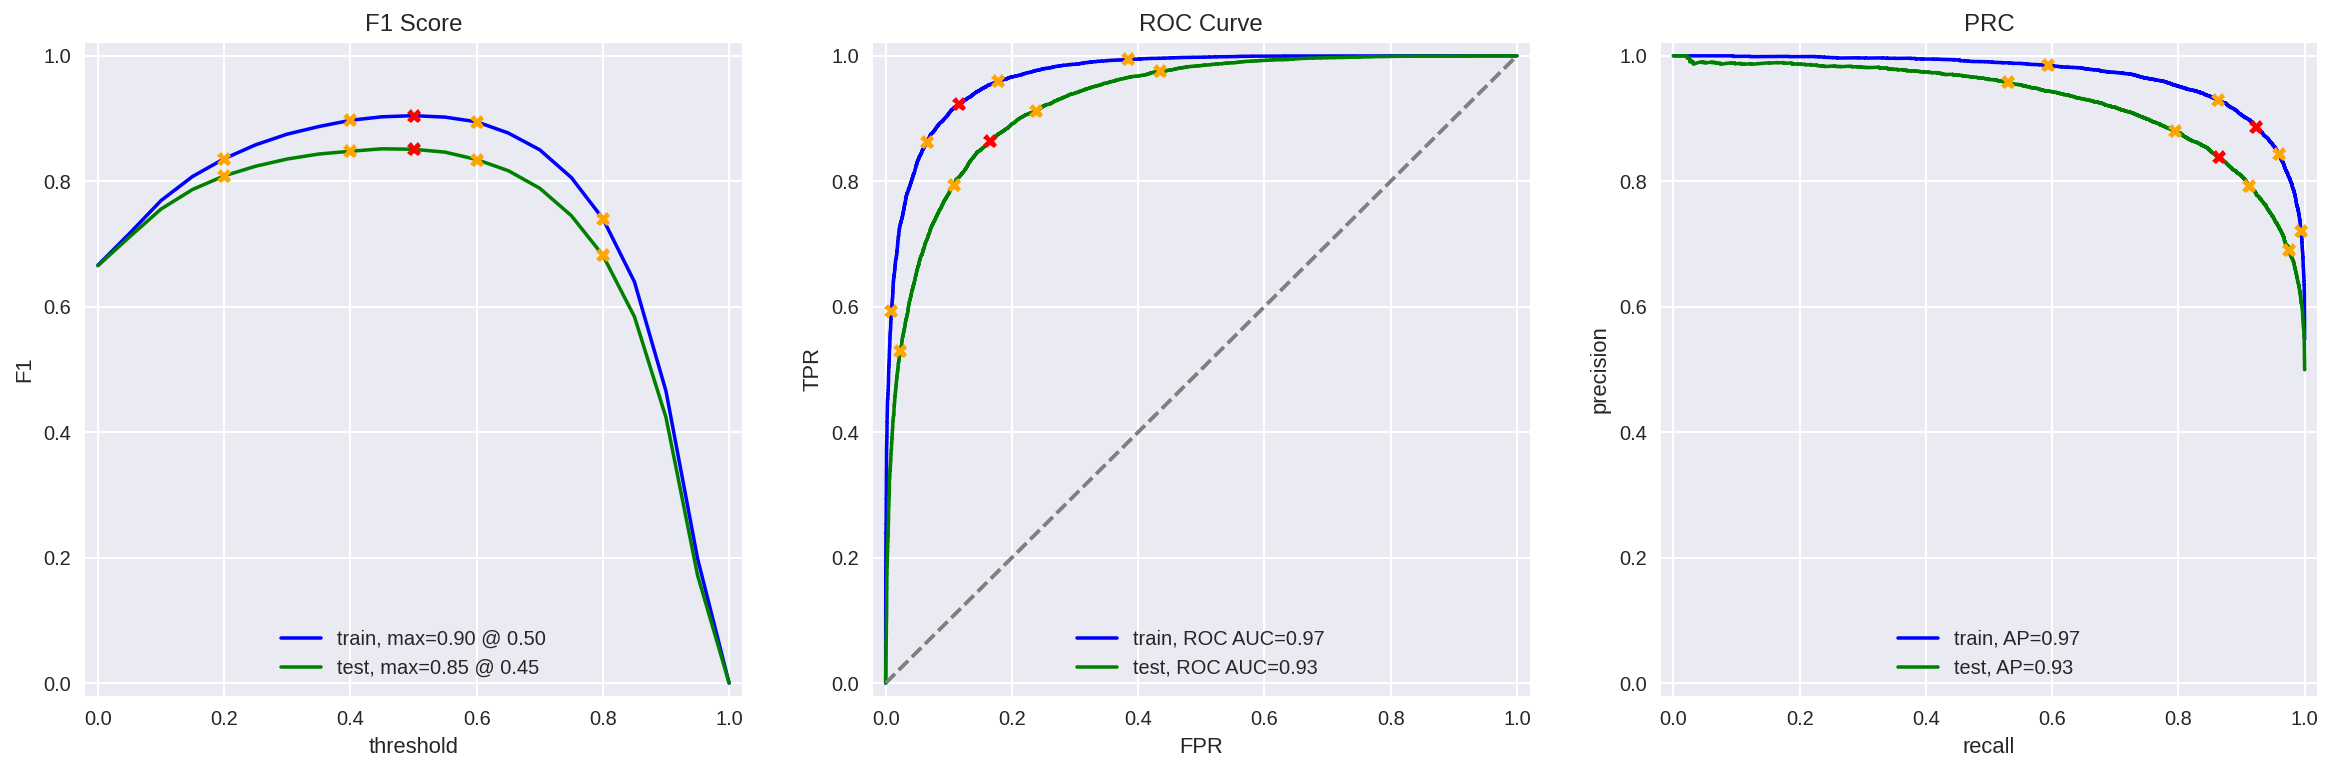

In [60]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

###  Model 9 - BERT

In [61]:
import torch
import transformers

In [62]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=10, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    for input_text in corpus[:200]:
        ids = tokenizer.encode(
            input_text.lower(),
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
        )
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask) 
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i : batch_size * (i + 1)])
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [64]:
#, force_device='cuda'

In [65]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(texts = df_reviews_train['review_norm'])#, force_device = 'cuda')

Using the cpu device.


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_42/2278809866.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [66]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(200, 768)
(23796,)


In [67]:
test_features_9 =  BERT_text_to_embeddings(texts = df_reviews_test['review_norm'])

Using the cpu device.


  0%|          | 0/20 [00:00<?, ?it/s]

In [68]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [69]:
len(test_features_9[0])

768

In [70]:
train_target_9 = train_target[:200]

In [71]:
test_target_9 = test_target[:200]

In [72]:
model_9 = LogisticRegression()

In [73]:
model_9.fit(train_features_9, train_target_9)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

          train  test
Accuracy    1.0  0.57
F1          1.0  0.53
APS         1.0  0.63
ROC AUC     1.0  0.57


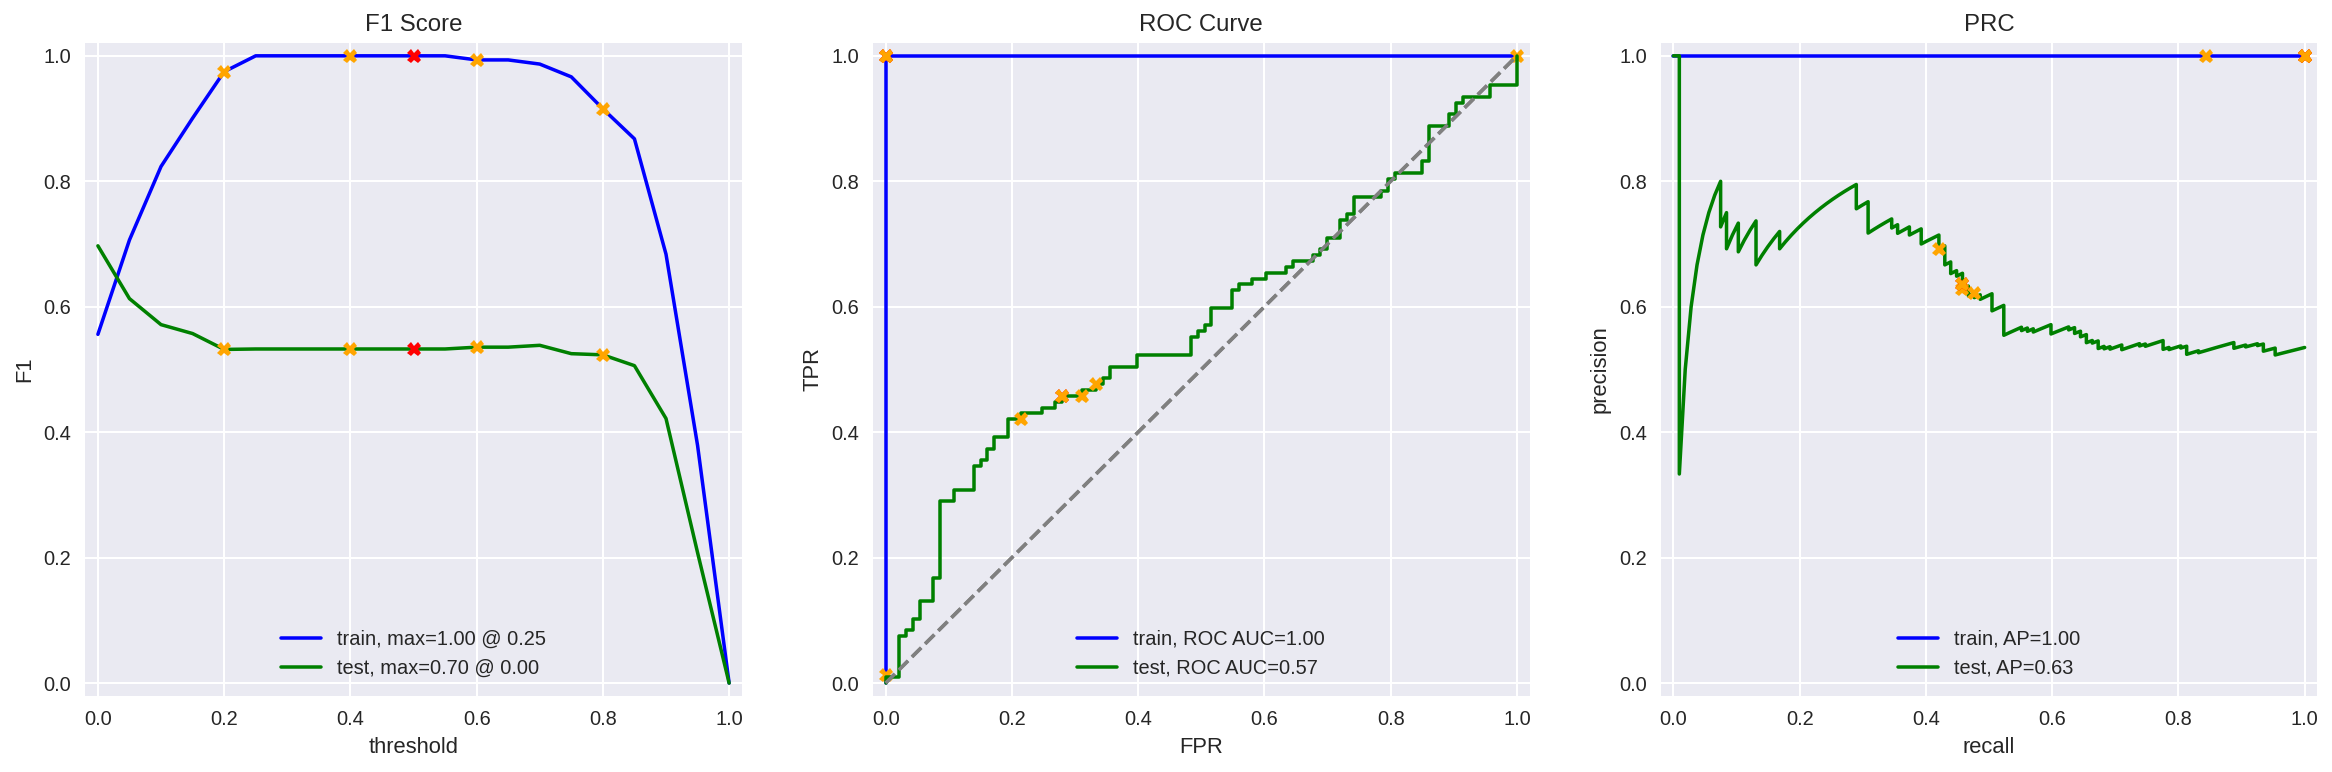

In [74]:
evaluate_model(model_9, train_features_9, train_target_9, test_features_9, test_target_9)

## My Reviews

In [75]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.', 
    'the movie did not fascinate me, as I was pretty bored the whole time watching the movie', 
    'even if they paid me one million dollars, i would not come back to watch the movie', 
    'the setting of the movie was well thought and they included great transitions throuhout the movie. It was so-so, but definitely worth checking it out', 
    'i have seen better movies', 
    'i think they did such a nice job in getting great actors. I was pleased with the movie'
], columns=['review'])

corpus_1 = my_reviews['review'].to_list()
corpus_1


['I did not simply like it, not my kind of movie.',
 'Well, I was bored and felt asleep in the middle of the movie.',
 'I was really fascinated with the movie',
 'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
 "I didn't expect the reboot to be so good! Writers really cared about the source material",
 "The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.",
 "What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!",
 'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
 'the movie did not fascinate me, as I was pretty bored the whole time watching the movie',
 'even if they paid me one million dollars, i would not come back to watch the movie',
 'the setting of the movie was well tho

In [76]:
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
my_reviews

,review,pos
0,"I did not simply like it, not my kind of movie.",0
1,"Well, I was bored and felt asleep in the middl...",0
2,I was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,1
5,"The movie had its upsides and downsides, but I...",1
6,What a rotten attempt at a comedy. Not a singl...,0
7,Launching on Netflix was a brave move & I real...,1
8,"the movie did not fascinate me, as I was prett...",0
9,"even if they paid me one million dollars, i wo...",0


In [77]:
review_norm_1 = [] 
for row in corpus_1:
    review_norm_1.append(clear_text(row))
review_norm_1

['i did not simply like it not my kind of movie',
 'well i was bored and felt asleep in the middle of the movie',
 'i was really fascinated with the movie',
 'even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab',
 "i didn't expect the reboot to be so good writers really cared about the source material",
 "the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again",
 "what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this",
 'launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama',
 'the movie did not fascinate me as i was pretty bored the whole time watching the movie',
 'even if they paid me one million dollars i would not come back to watch the movie',
 'the setting of the movie was well thought and they include

In [78]:

my_reviews['review_norm'] = review_norm_1

my_reviews

,review,pos,review_norm
0,"I did not simply like it, not my kind of movie.",0,i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",0,well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,1,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,0,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,1,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",1,the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,0,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,1,launching on netflix was a brave move i really...
8,"the movie did not fascinate me, as I was prett...",0,the movie did not fascinate me as i was pretty...
9,"even if they paid me one million dollars, i wo...",0,even if they paid me one million dollars i wou...


### Model 1
In the following section, we tested new review using our models to see how well our models performed with new data. For each new review, there's an assigned class: 0 meaning negative review and 1 meaning postitive review. Similarly, for each new review, the models will return a probability of classification, which will return how each models classified the new reviews.  

In [99]:
model_1_corpus_new_lem = []

for row in corpus_test.to_list():
    lemmatizer  = WordNetLemmatizer() 
    tokens = word_tokenize(row.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    model_1_corpus_new_lem.append(" ".join(lemmas))

In [100]:
texts = my_reviews['review_norm']
train_features_1 = count_tf_idf.fit_transform(model_1_corpus_train_lem) 
print(train_features_1.shape)
new_test_features_1 = count_tf_idf.transform(texts)
print(new_test_features_1.shape)

(23796, 64447)
(13, 64447)


In [101]:


my_reviews_pred_prob1 = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob1[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didn't expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.09:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.22:  the movie did not fascinate me as i was pretty bored the whole time watching the movie
0.11:  even if they paid me one million dollars i would not come back to watch the movie
0.99:  the setting of the movie was well thought and they included great transitions throuhout the movie it
0.50:  i have se

In [112]:
from sklearn.metrics import mean_squared_error

#calculating rmse from actual polarity of review to predicted classification probability

mean_squared_error(my_reviews_pred_prob1, my_reviews['pos'])**0.5

0.3087162832845394

### Model 2

In [113]:
texts = my_reviews['review_norm']

def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

spacy_features_new_lem = []

for row in texts.to_list():
    new = text_preprocessing_3(row)
    spacy_features_new_lem.append(new)

In [114]:
spacy_features_new_lem

['I do not simply like it not my kind of movie',
 'well I be bored and feel asleep in the middle of the movie',
 'I be really fascinated with the movie',
 'even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab',
 'I do not expect the reboot to be so good writer really care about the source material',
 'the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again',
 'what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this',
 'launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama',
 'the movie do not fascinate I as I be pretty bored the whole time watch the movie',
 'even if they pay I one million dollar I would not come back to watch the movie',
 'the setting of the movie be well think and they include great transition throuhout the 

In [115]:
train_features_2 = count_tf_idf.fit_transform(spacy_features_train_lem)
print(train_features_2.shape)
new_test_features_2 = count_tf_idf.transform(spacy_features_new_lem)
print(new_test_features_2.shape)


(23796, 59165)
(13, 59165)


In [116]:
texts = new_test_features_2

In [117]:
texts = my_reviews['review_norm']

my_reviews_pred_prob2 = model_2.predict_proba(count_tf_idf.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob2[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.26:  the movie did not fascinate me as i was pretty bored the whole time watching the movie
0.08:  even if they paid me one million dollars i would not come back to watch the movie
0.98:  the setting of the movie was well thought and they included great transitions throuhout the movie it
0.96:  i have se

In [118]:
mean_squared_error(my_reviews_pred_prob2, my_reviews['pos'])**0.5

0.403477442255251

### Model 4

In [121]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = count_tf_idf
my_reviews_pred_prob3 = model_3.predict_proba(count_tf_idf.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob3[i]:.2f}:  {review}')

0.61:  i did not simply like it not my kind of movie
0.48:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.50:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.69:  i didn't expect the reboot to be so good writers really cared about the source material
0.72:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.39:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.73:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.58:  the movie did not fascinate me as i was pretty bored the whole time watching the movie
0.42:  even if they paid me one million dollars i would not come back to watch the movie
0.90:  the setting of the movie was well thought and they included great transitions throuhout the movie it
0.73:  i have se

In [122]:
mean_squared_error(my_reviews_pred_prob3, my_reviews['pos'])**0.5

0.4365753986833235

### Model 9

In [123]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=False)

my_reviews_pred_prob9 = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob9[i]:.2f}:  {review}')

Using the cpu device.


  0%|          | 0/20 [00:00<?, ?it/s]

0.05:  i did not simply like it not my kind of movie
0.20:  well i was bored and felt asleep in the middle of the movie
0.18:  i was really fascinated with the movie
0.09:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.00:  i didn't expect the reboot to be so good writers really cared about the source material
0.13:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.22:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.14:  the movie did not fascinate me as i was pretty bored the whole time watching the movie
0.06:  even if they paid me one million dollars i would not come back to watch the movie
0.13:  the setting of the movie was well thought and they included great transitions throuhout the movie it
0.15:  i have se

In [126]:
mean_squared_error(my_reviews_pred_prob9[:13], my_reviews['pos'])**0.5

0.6011314577798165

## Conclusions

The results from the test data are depicted in the table below: 

|Model Name | Model description | Accuracy score | ROC AUC score  | F1 score |
|-------------|-------------------|----------------|----------------|----------|
| model 0     |DummyClassifier, constant | 0.5        |  0.5         |   0.0      |
| model 1        |  NLTK, TF-IDF, Logistic Regresion       |    0.88       |    0.95       |     0.88    |
|  model 2       |  spaCy, TF-IDF, Logistic Regression        |   0.88        |  0.95         |   0.88      |
|   model 4     |  spaCy, TF-IDF, LGBMclassifier       |    0.85    |     0.93      |    0.85     |
| model 9 | BERT | 0.57 | 0.57 | 0.53 |


From the table above, we observed that the model that presented the highest accuracy score were model 1 and model 2, with an accuracy score of 0.88. Similarly, models 1 and 2 scores the highest F1 score and were the only tests that scored higher than the minimum required score of 0.85. All the models performed better than the constant model 0 in terms of accuracy score, ROC AUC score, and F1 score. 

The table below summarizes the each of the rmse values for the new reviews. The rmse values were evaluated between the expected polarity of each new review and the probability values predicted by each of the models. 

|Model Name | rmse value | 
|------|------|
|model 1      |  0.3087    |
|model 2      |   0.4034   |
|model 4     |  0.4365    |
|model 9     |   0.6011   |

From these two tables, we can conclude that model 1 performed better compared to the other models because it had the highest accuracy score, F1 score, anf ROC AUC score from evaluating the test data. Similarly, the rmse of model 1 was the smallest compared to the other model, with a rmse score of 0.3081. This means that, on average, model 1 predicted the classification of each new review with a distance of 0.3087 points away from their true polarity. 